In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import re

In [37]:
POWERS = ['0', '4', '3', '2', '1']
# POWERS = ['0', '2']
INDEX_TIME_UNIT = 1000 # number of tweets
QUERY_TIME_UNIT = 1000 # number of tweets
SIMILARITY_THRE = 0.5
NUMBER_OF_RUNS = 3
OUTPUT_DIR = "./output_expm1/n9/"

def get_chance(power):
    if power == '0':
        return '100'
    elif power == '4':
        return '93.75'
    elif power == '3':
        return '87.5'
    elif power == '2':
        return '75'
    elif power == '1':
        return '50'
    
def get_power_index(power):
    if power == '0':
        return 0
    elif power == '4':
        return 1
    elif power == '3':
        return 2
    elif power == '2':
        return 3
    elif power == '1':
        return 4
    
SUMMARY_INDEX = pd.Index(['Run', 'Chance', 'Index time unit', 'Query time unit', 'Similarity threshold', 
                 'Query counts', 'Indexed tweet counts', 'Index size'])
SUMMARY_COL = ['Summary_' + get_chance(p) + '%' for p in POWERS]
QUERY_RESULT_COL = ['Result_' + get_chance(p) + '%' for p in POWERS]
QUERY_SIMILARITY_COL = ['Similarity_' + get_chance(p) + '%' for p in POWERS]
QUERY_LOOKUPS_COL = ['Lookups_' + get_chance(p) + '%' for p in POWERS]
INDEX_TIME_COL = ['Index_time_run{}_{}%'.format(str(i+1), get_chance(p)) for p in POWERS for i in range(NUMBER_OF_RUNS)]
QUERY_TIME_COL = ['Query_time_run{}_{}%'.format(str(i+1), get_chance(p)) for p in POWERS for i in range(NUMBER_OF_RUNS)]

FREQ_TABLES_X = ['Posting_list_length_' + get_chance(p) + '%' for p in POWERS]
QUERY_RECALL_X = ['Query_recall_' + get_chance(p) + '%' for p in POWERS]
QUERY_PRECISION_X = ['Query_precision_' + get_chance(p) + '%' for p in POWERS]
QUERY_LESS_LOOKUPS_X = ['Query_of_less_lookups_' + get_chance(p) + '%' for p in POWERS]
AVERAGE_LOOKUPS_X = ['Average_lookup_counts_' + get_chance(p) + '%' for p in POWERS]
PLOT_X = [get_chance(p) + '%' for p in POWERS]

# Run Experiment  One and Read in Results

* Use single terms to construct index
* Each term has a 100% chance to 50% chance to be included in the index or fingerprint

In [38]:
def runSketchTweets(jar, index_time_unit, query_time_unit, chance_power, similarity_threshold, n, output_dir):
    for run in range (1, n+1):
        os.system("java -jar ./{}.jar -iu {} -qu {} -p {} -s {} -n {} -o {}"
        .format(jar, index_time_unit, query_time_unit, chance_power, similarity_threshold, run, output_dir))

In [39]:
# This function runs the experiment and compares the results including:
# - the size of the index and doc lists 
# - time for constructing the index and executing query 
# - number of lookups before finding the match

def run_expm1():
    for p in POWERS:
        runSketchTweets("SketchingTweet-v2-n9", INDEX_TIME_UNIT, QUERY_TIME_UNIT, p, SIMILARITY_THRE, NUMBER_OF_RUNS, OUTPUT_DIR)
    results = load_expm1_csv(OUTPUT_DIR)
    return results

In [40]:
def load_expm1_csv(directory):
    '''
    Returns a dictionary of results.
    The dictionary keys are: summary, termfreq, query_results_similarity_lookups, index_time, query_time
    '''
    results = {}
    summary = [0] * len(POWERS)
    termfreq = [0] * len(POWERS)
    query_result = [0] * len(POWERS)
    query_similarity = [0] * len(POWERS)
    query_lookups = [0] * len(POWERS)
    index_time = [[0 for j in range(NUMBER_OF_RUNS)] for i in range(len(POWERS))]
    query_time = [[0 for j in range(NUMBER_OF_RUNS)] for i in range(len(POWERS))]
      

    for root, _, files in os.walk(directory):
        for file in files:
            filename = re.match( r'Epoch_(\d+)_iu_(\d+)_qu_(\d+)_p_(\d+)_s_([\.\d]+)_(.+).csv', file)  
#             print(filename.group(3),filename.group(4),filename.group(5),filename.group(6))
            name = filename.group(6)
            power = filename.group(4)

            if name == "summary":    
                for p in POWERS:
                    if power == p:
                        summary[get_power_index(power)] = pd.read_csv(directory + "/" + file, header=None)

            if name == "term_freq":
                for p in POWERS:
                    if power == p:
                        termfreq[get_power_index(power)] = pd.read_csv(directory + "/" + file, header=None)
                    
            if name == "query_result":
                for p in POWERS:
                    if power == p:
                        query_result[get_power_index(power)] = pd.read_csv(directory + "/" + file, header=None)
                    
            if name == "query_similarity":
                for p in POWERS:
                    if power == p:
                        query_similarity[get_power_index(power)] = pd.read_csv(directory + "/" + file, header=None)
                    
            if name == "lookups":
                for p in POWERS:
                    if power == p:
                        query_lookups[get_power_index(power)] = pd.read_csv(directory + "/" + file, header=None)
            
            if name == "index_time":
                run = filename.group(1)
                for p in POWERS:
                    if power == p:
                        for i in range(0,NUMBER_OF_RUNS):
                            if run == str(i+1):
                                index_time[get_power_index(power)][i] = pd.read_csv(directory + "/" + file, header=None)
                    
            if name == "query_time":
                run = filename.group(1)
                for p in POWERS:
                    if power == p:
                        for i in range(0,NUMBER_OF_RUNS):
                            if run == str(i+1):
                                query_time[get_power_index(power)][i] = pd.read_csv(directory + "/" + file, header=None)
                  

    summary = pd.concat(summary, 1)
    summary = summary.set_index(SUMMARY_INDEX)
    summary.columns = SUMMARY_COL
#     print(summary)
    
    for table in termfreq:
        termfreq_index = table.iloc[:,0]
        table.set_index(termfreq_index, inplace=True)
        table.drop(table.columns[0], axis=1, inplace=True)
        table.columns = ['number_of_terms', 'posting_count']
#     print(termfreq)
    
    query_result = pd.concat(query_result, 1)
    query_result.columns = QUERY_RESULT_COL
#     print(query_result)
    
    query_similarity = pd.concat(query_similarity, 1)
    query_similarity.columns = QUERY_SIMILARITY_COL
#     print(query_similarity)

    query_lookups = pd.concat(query_lookups, 1)
    query_lookups.columns = QUERY_LOOKUPS_COL
#     print(query_lookups)

    query_result_similarity_lookup = [query_result, query_similarity, query_lookups]
    query_result_similarity_lookup = pd.concat(query_result_similarity_lookup, 1)
#     print(query_result_similarity_lookup)
    
    index_time_dfs = []
    for p in index_time:
        index_time_df = pd.concat(p, 1)
        index_time_dfs.append(index_time_df)
    index_time = pd.concat(index_time_dfs, 1)
    index_time.columns = INDEX_TIME_COL
    
    query_time_dfs = []
    for p in query_time:
        query_time_df = pd.concat(p, 1)
        query_time_dfs.append(query_time_df)
    query_time = pd.concat(query_time_dfs, 1)
    query_time.columns = QUERY_TIME_COL
    
    results['summary'] = summary
    results['termfreq'] = termfreq
    results['query_result_similarity_lookup'] = query_result_similarity_lookup
    results['index_time'] = index_time
    results['query_time'] = query_time
  
    return results

In [41]:
results = run_expm1() 

# Process Results

In [42]:
def plot_linechart(title, x, y, x_label, y_label, scale='linear'):
    plt.plot(x, y)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.yscale(scale)
    plt.show()
    
def plot_scatter(title, x, y, x_label, y_label, scale='linear'):
    plt.scatter(x, y, s=0.5)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.yscale(scale)
    plt.show()
    
def plot_barchart(title, x, y, x_label, y_label, color="#66B3BA"):
    layer = sns.barplot(x=x, y=y, color=color)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()
    
def plot_boxplot(title, data, y_label, scale='linear'):
    layer = sns.boxplot(data=data)
    layer = sns.stripplot(data=data, color="orange", jitter=0.2, size=1.5)
    plt.title(title)
    plt.ylabel(y_label)
    plt.yscale(scale)
    plt.show()

## Index size comparison

In [43]:
summary = results['summary']
summary

,Summary_100%,Summary_93.75%,Summary_87.5%,Summary_75%,Summary_50%
Run,1,1,1,1,1
Chance,100.0%,93.75%,87.5%,75.0%,50.0%
Index time unit,1000,1000,1000,1000,1000
Query time unit,1000,1000,1000,1000,1000
Similarity threshold,0.500000,0.500000,0.500000,0.500000,0.500000
Query counts,22852,22852,22852,22852,22852
Indexed tweet counts,206118,206118,206118,206118,206118
Index size,206665,194173,181418,155941,104664


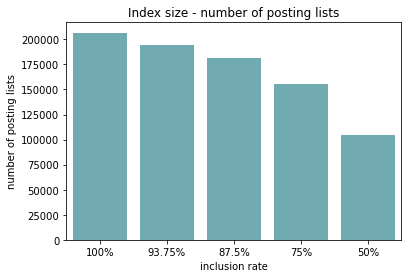

Summary_100%      206665
Summary_93.75%    194173
Summary_87.5%     181418
Summary_75%       155941
Summary_50%       104664
Name: Index size, dtype: object

In [44]:
# index size - number of posting lists
def compare_index_size(sizes, title):
    data = pd.to_numeric(sizes).to_list()
    plot_barchart(title, PLOT_X, data, 'inclusion rate', 'number of posting lists')

compare_index_size(summary.loc['Index size'], "Index size - number of posting lists")
summary.loc['Index size']

## Documnet list length comparison

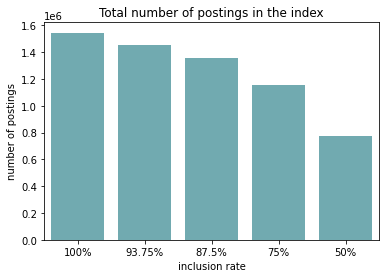

Total number of postings:


[1545362, 1455735, 1357375, 1158627, 774315]

In [45]:
freq_tables = results['termfreq']
posting_list_length_distribution = [table['posting_count'].value_counts().sort_index(inplace=False) for table in freq_tables]
total_posting_counts = [sum(table['posting_count']) for table in freq_tables]
plot_barchart('Total number of postings in the index', PLOT_X, total_posting_counts, 'inclusion rate', 'number of postings')
print('Total number of postings:')
total_posting_counts

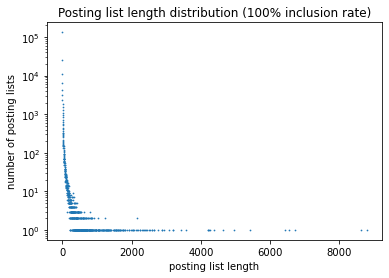

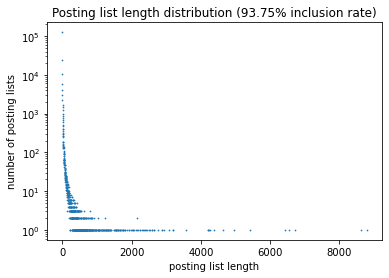

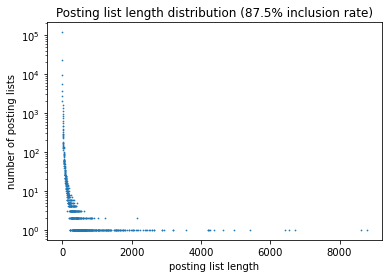

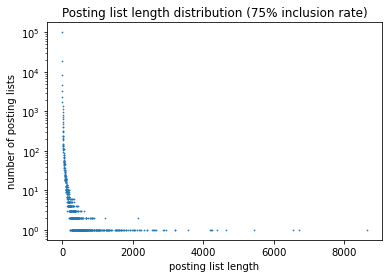

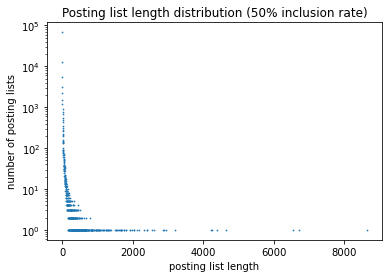

In [46]:
def compare_postinglist_length_distribution(PLOT_X, posting_list_length_distribution):
    for i in range(len(PLOT_X)):
        title = f'Posting list length distribution ({PLOT_X[i]} inclusion rate)'
        x = posting_list_length_distribution[i].index
        y = posting_list_length_distribution[i]
        plot_scatter(title, x, y, 'posting list length', 'number of posting lists', scale='log')   
compare_postinglist_length_distribution(PLOT_X, posting_list_length_distribution)

Average posting list length
[7.477618367890064, 7.497103098783044, 7.482030449018289, 7.429906182466445, 7.398102499426737]


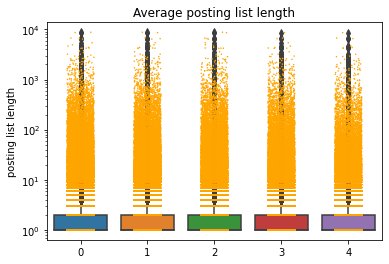

In [47]:
def compare_posting_list_len(PLOT_X, freq_tables):
    lengths = [table['posting_count'] for table in freq_tables]
    avgs = [sum(l)/len(l) for l in lengths]
    print("Average posting list length")
    print(avgs)
#     index15 = [int(round(len(l)*0.15,0)) for l in lengths]
#     index85 = [int(round(len(l)*0.85,0)) for l in lengths]
#     nooutlier_lengths = [ lengths[i][index15[i]:index85[i]] for i in range(len(lengths))]
    plot_boxplot(f'Average posting list length', lengths, 'posting list length', scale='log')
    
compare_posting_list_len(PLOT_X, freq_tables)

## Query Recall

In [48]:
query_result_similarity_lookup = results['query_result_similarity_lookup']
query_result_similarity_lookup

,Result_100%,Result_93.75%,Result_87.5%,Result_75%,Result_50%,Similarity_100%,Similarity_93.75%,Similarity_87.5%,Similarity_75%,Similarity_50%,Lookups_100%,Lookups_93.75%,Lookups_87.5%,Lookups_75%,Lookups_50%
0,197710,197710,197710,197710,197710,0.66667,0.71429,0.71429,0.71429,0.50000,3888,1582,1582,1582,236
1,152573,152573,152573,103379,103379,0.50000,0.50000,0.50000,0.66667,0.66667,6246,6246,6246,2250,2250
2,-1,-1,-1,-1,152451,0.00000,0.00000,0.00000,0.00000,0.50000,-1,-1,-1,-1,384
3,-1,-1,-1,-1,-1,0.00000,0.00000,0.00000,0.00000,0.00000,-1,-1,-1,-1,-1
4,-1,-1,-1,-1,205139,0.00000,0.00000,0.00000,0.00000,0.50000,-1,-1,-1,-1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22847,-1,-1,-1,196136,205121,0.00000,0.00000,0.00000,0.50000,1.00000,-1,-1,-1,156,1
22848,-1,-1,-1,-1,-1,0.00000,0.00000,0.00000,0.00000,0.00000,-1,-1,-1,-1,-1
22849,-1,-1,-1,-1,-1,0.00000,0.00000,0.00000,0.00000,0.00000,-1,-1,-1,-1,-1
22850,-1,-1,-1,-1,-1,0.00000,0.00000,0.00000,0.00000,0.00000,-1,-1,-1,-1,-1


In [49]:
has_true_similar = query_result_similarity_lookup[QUERY_RESULT_COL[0]] != -1
true_similar = query_result_similarity_lookup[has_true_similar]
num_true_similar = true_similar.shape[0]
true_similar

,Result_100%,Result_93.75%,Result_87.5%,Result_75%,Result_50%,Similarity_100%,Similarity_93.75%,Similarity_87.5%,Similarity_75%,Similarity_50%,Lookups_100%,Lookups_93.75%,Lookups_87.5%,Lookups_75%,Lookups_50%
0,197710,197710,197710,197710,197710,0.66667,0.71429,0.71429,0.71429,0.50000,3888,1582,1582,1582,236
1,152573,152573,152573,103379,103379,0.50000,0.50000,0.50000,0.66667,0.66667,6246,6246,6246,2250,2250
8,46552,205551,205551,205551,205551,0.60000,0.50000,0.66667,0.66667,0.66667,43665,112,75,75,75
11,205082,205082,205082,205082,205111,0.50000,0.50000,0.50000,0.60000,0.50000,108,108,108,90,60
13,177541,177541,177541,177541,206008,0.60000,0.60000,0.60000,0.60000,0.66667,7450,7450,7450,7450,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22839,25509,25509,25509,127129,205712,0.60000,0.60000,0.60000,0.50000,0.50000,3420,3420,3420,836,2
22841,206059,206059,206059,206059,206059,1.00000,1.00000,1.00000,1.00000,1.00000,7,7,7,5,4
22844,206109,206109,206109,206109,206109,0.60000,0.60000,0.60000,0.75000,1.00000,5,5,5,4,2
22846,186451,186451,186451,186451,-1,0.62500,0.62500,0.62500,0.50000,0.00000,120,120,120,78,-1


In [50]:
num_correct_searches = []
correct_searches = []
for i in range(len(QUERY_RESULT_COL)):
    is_correct_search = true_similar[QUERY_RESULT_COL[0]] == true_similar[QUERY_RESULT_COL[i]]
    correct_search = true_similar[is_correct_search]
    correct_searches.append(correct_search)
    num_correct_searches.append(correct_search.shape[0])
print('Number of true similar tweets that we found: ')
num_correct_searches

Number of true similar tweets that we found: 


[7797, 6895, 6031, 4446, 2487]

Using 100% of terms, we can find 100.0% truly similar tweets
Using 93.75% of terms, we can find 88.43% truly similar tweets
Using 87.5% of terms, we can find 77.35% truly similar tweets
Using 75% of terms, we can find 57.02% truly similar tweets
Using 50% of terms, we can find 31.9% truly similar tweets


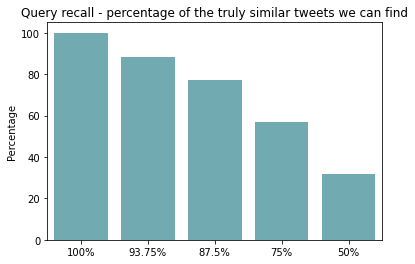

In [51]:
def compare_query_recall(recalls, title): 
    layer = sns.barplot(x=PLOT_X, y=recalls, color="#66B3BA")
    plt.title(title)
    layer.set(ylabel='Percentage')
    plt.show()

recalls = []
true_searches = []
for i in range(len(num_correct_searches)):
    true_searches.append(num_correct_searches[i])
    recall = round((num_correct_searches[i]/num_true_similar) * 100, 2)
    recalls.append(recall)
    chance = PLOT_X[i]
    print('Using {} of terms, we can find {}% truly similar tweets'.format(chance, recall))
    
compare_query_recall(recalls, 'Query recall - percentage of the truly similar tweets we can find')

## Query Precision

In [52]:
is_predict_similar = query_result_similarity_lookup['Result_75%'] != -1
predict_similar = query_result_similarity_lookup[is_predict_similar]
num_predict_similar = predict_similar.shape[0]
predict_similar

num_predict_similar_lst = []
predict_similar_lst = []
for i in range(len(QUERY_RESULT_COL)):
    is_predict_similar = query_result_similarity_lookup[QUERY_RESULT_COL[i]] != -1
    predict_similar = query_result_similarity_lookup[is_predict_similar]
    predict_similar_lst.append(predict_similar)
    num_predict_similar_lst.append(predict_similar.shape[0])
print("The number of tweets that we think are similar: ")
num_predict_similar_lst

The number of tweets that we think are similar: 


[7797, 8630, 9427, 11118, 15293]

Using 100% of terms, 100.0% tweets that we found similar are truly similar tweets
Using 93.75% of terms, 79.9% tweets that we found similar are truly similar tweets
Using 87.5% of terms, 63.98% tweets that we found similar are truly similar tweets
Using 75% of terms, 39.99% tweets that we found similar are truly similar tweets
Using 50% of terms, 16.26% tweets that we found similar are truly similar tweets


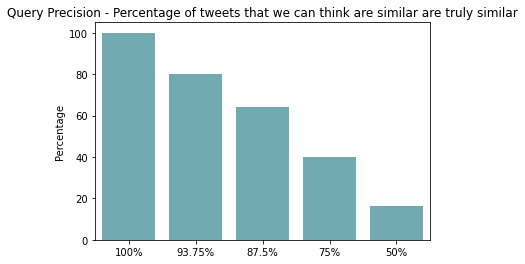

In [53]:
def compare_query_precision(precisions, title): 
    layer = sns.barplot(x=PLOT_X, y=precisions, color="#66B3BA")
    layer.set(ylabel='Percentage')
    plt.title(title)
    plt.show()

precisions = []
for i in range(len(num_predict_similar_lst)):
    precision = round((num_correct_searches[i]/num_predict_similar_lst[i]) * 100, 2)
    precisions.append(precision)
    chance = PLOT_X[i]
    print('Using {} of terms, {}% tweets that we found similar are truly similar tweets'.format(chance, precision))
    
compare_query_precision(precisions, 'Query Precision - Percentage of tweets that we can think are similar are truly similar')

## Number of searches that need fewer lookups

In [54]:
correct_search

,Result_100%,Result_93.75%,Result_87.5%,Result_75%,Result_50%,Similarity_100%,Similarity_93.75%,Similarity_87.5%,Similarity_75%,Similarity_50%,Lookups_100%,Lookups_93.75%,Lookups_87.5%,Lookups_75%,Lookups_50%
0,197710,197710,197710,197710,197710,0.66667,0.71429,0.71429,0.71429,0.5,3888,1582,1582,1582,236
19,204516,204516,205909,205909,204516,0.66667,0.60000,0.50000,0.66667,1.0,312,200,4,3,1
48,205111,205111,205111,205111,205111,0.62500,0.62500,0.66667,0.80000,1.0,168,168,84,70,42
58,205316,205316,205316,205316,205316,0.66667,0.66667,0.66667,0.66667,0.8,108,108,108,108,45
78,35710,35710,35710,35710,35710,1.00000,1.00000,1.00000,1.00000,1.0,28692,28692,17311,17311,11538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22834,206059,206059,206059,206059,206059,1.00000,1.00000,1.00000,1.00000,1.0,7,7,7,5,4
22837,206059,206059,206059,206059,206059,1.00000,1.00000,1.00000,1.00000,1.0,7,7,7,5,4
22841,206059,206059,206059,206059,206059,1.00000,1.00000,1.00000,1.00000,1.0,7,7,7,5,4
22844,206109,206109,206109,206109,206109,0.60000,0.60000,0.60000,0.75000,1.0,5,5,5,4,2


In [55]:
query_of_less_lookups = []
less_search_lst = []
for i in range(len(QUERY_LOOKUPS_COL)):
    if i != 0:
        is_less_search = correct_searches[i][QUERY_LOOKUPS_COL[0]] > correct_searches[i][QUERY_LOOKUPS_COL[i]]
        less_search = correct_searches[i][is_less_search]
        less_search_lst.append(less_search)
        query_of_less_lookups.append(less_search.shape[0])
    else:
        less_search_lst.append(None)
        query_of_less_lookups.append(0)
print("The number of tweets that need less lookups before correctly finding the true similar tweets: ")
query_of_less_lookups

The number of tweets that need less lookups before correctly finding the true similar tweets: 


[0, 1501, 2537, 3358, 2374]

Using 100% of terms, 0.0% queries need less lookups before correctly finding the true similar tweets
Using 93.75% of terms, 21.77% queries need less lookups before correctly finding the true similar tweets
Using 87.5% of terms, 42.07% queries need less lookups before correctly finding the true similar tweets
Using 75% of terms, 75.53% queries need less lookups before correctly finding the true similar tweets
Using 50% of terms, 95.46% queries need less lookups before correctly finding the true similar tweets


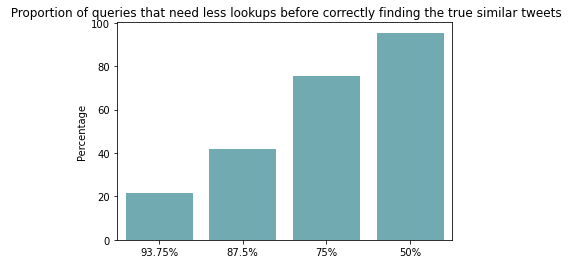

In [56]:
def compare_number_of_tweets_need_less_lookups(reduces, title): 
    layer = sns.barplot(x=PLOT_X[1:], y=reduces, color="#66B3BA")
    layer.set(ylabel='Percentage')
    plt.title(title)
    plt.show()

proportions = []
for i in range(len(query_of_less_lookups)):
    proportion = round((query_of_less_lookups[i] / num_correct_searches[i]) * 100, 2)
    proportions.append(proportion)
    chance = PLOT_X[i]
    print('Using {} of terms, {}% queries need less lookups before correctly finding the true similar tweets'.format(chance, proportion))
    
compare_number_of_tweets_need_less_lookups(proportions[1:], ' Proportion of queries that need less lookups before correctly finding the true similar tweets')

## Number of average lookups

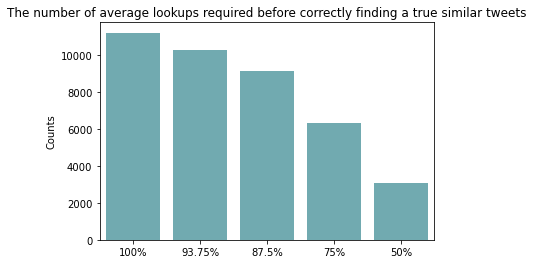

In [57]:
def compare_number_of_avg_lookups(reduces, title): 
    layer = sns.barplot(x=PLOT_X, y=reduces, color="#66B3BA")
    layer.set(ylabel='Counts')
    plt.title(title)
    plt.show()

avg_lookups = []
for i in range(len(QUERY_LOOKUPS_COL)):
    avg_lookup = np.average(np.array(correct_searches[i][QUERY_LOOKUPS_COL[i]]))
    avg_lookups.append(avg_lookup)

compare_number_of_avg_lookups(avg_lookups, 'The number of average lookups required before correctly finding a true similar tweets')

In [58]:
reduces = []
print('Comparing to using all the terms:')
for i in range(len(avg_lookups)):
    if i != 0:
        reduce = round(((avg_lookups[0] - avg_lookups[i]) / avg_lookups[0]) * 100, 2)
        reduces.append(reduce)
        chance = PLOT_X[i]
        print('By using {} of terms, {}% of less lookups are needed for correctly finding a true similar tweets'.format(chance, reduce))

Comparing to using all the terms:
By using 93.75% of terms, 8.39% of less lookups are needed for correctly finding a true similar tweets
By using 87.5% of terms, 18.36% of less lookups are needed for correctly finding a true similar tweets
By using 75% of terms, 43.48% of less lookups are needed for correctly finding a true similar tweets
By using 50% of terms, 72.55% of less lookups are needed for correctly finding a true similar tweets


## Index time comparison

In [59]:
index_time = results['index_time']
index_time

,Index_time_run1_100%,Index_time_run2_100%,Index_time_run3_100%,Index_time_run1_93.75%,Index_time_run2_93.75%,Index_time_run3_93.75%,Index_time_run1_87.5%,Index_time_run2_87.5%,Index_time_run3_87.5%,Index_time_run1_75%,Index_time_run2_75%,Index_time_run3_75%,Index_time_run1_50%,Index_time_run2_50%,Index_time_run3_50%
0,9.7531,13.8014,10.9473,13.7358,16.5125,12.5189,12.4669,15.9098,13.7248,12.8515,13.8451,13.2277,18.8627,13.5452,15.2355
1,4.5377,6.5417,4.7946,6.1113,8.4716,6.6235,6.4284,6.8834,6.2580,5.6911,5.8448,5.5361,9.8064,5.9363,6.6852
2,4.8332,5.5523,4.9158,6.2214,5.7803,6.8177,5.0853,5.8863,5.9623,4.9702,4.2635,4.4494,8.0439,5.5191,5.1876
3,4.4129,7.5738,4.2050,4.9748,5.4437,5.6247,4.6429,5.2466,5.1046,4.6304,3.7521,4.1306,7.5109,4.4486,4.8215
4,3.9714,7.3004,4.3633,5.0006,5.4870,5.5459,5.1154,5.4478,4.1522,4.9057,3.7092,4.4641,6.6703,4.4919,7.1532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,1.7722,2.0413,2.4221,3.2572,2.2860,2.1593,2.8788,3.2032,2.1358,2.6130,2.4023,2.4209,2.6859,2.6299,15.5568
202,1.7158,2.0769,2.3808,2.2513,2.2287,2.0926,2.4887,2.9505,2.0877,2.5458,2.3994,2.3523,3.2068,2.6163,2.2779
203,1.6729,2.0786,2.3386,2.1775,2.1689,2.0456,2.2527,3.0609,2.0382,2.5413,2.4339,2.2776,2.6091,2.5735,1.9189
204,1.6741,2.0338,2.6458,2.1470,2.1502,2.1144,2.1875,3.1319,2.0562,2.5378,2.3175,2.3452,2.6076,2.5370,1.8528


By using 100% of terms, the average time for indexing 1000 tweets is 3.058 milliseconds
By using 93.75% of terms, the average time for indexing 1000 tweets is 3.4068 milliseconds
By using 87.5% of terms, the average time for indexing 1000 tweets is 3.4267 milliseconds
By using 75% of terms, the average time for indexing 1000 tweets is 3.1025 milliseconds
By using 50% of terms, the average time for indexing 1000 tweets is 3.3118 milliseconds


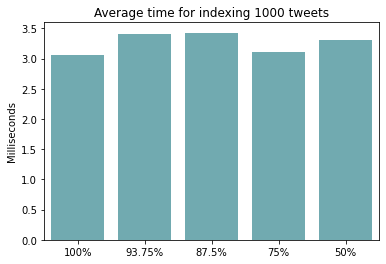

In [60]:
def compare_time(avg_time, title): 
    layer = sns.barplot(x=PLOT_X, y=avg_time, color="#66B3BA")
    layer.set(ylabel='Milliseconds')
    plt.title(title)
    plt.show()

index_time_avgs = []
for col in index_time.columns:
    index_time_avgs.append(np.average(np.array(index_time[col])))

index_time_avgs2 = []
c = 0
acc = 0
for avg in index_time_avgs:
    if c < 2:
        acc += avg
        c += 1
        
    else:
        acc += avg
#         print(acc)
        index_time_avgs2.append(round(acc/3 , 4))
        acc = 0
        c = 0

for i in range(len(index_time_avgs2)):
    print('By using {} of terms, the average time for indexing {} tweets is {} milliseconds'.format(PLOT_X[i], INDEX_TIME_UNIT, index_time_avgs2[i]))
compare_time(index_time_avgs2, 'Average time for indexing {} tweets'.format(INDEX_TIME_UNIT))

## Query time comparison

In [61]:
query_time = results['query_time']
query_time

,Query_time_run1_100%,Query_time_run2_100%,Query_time_run3_100%,Query_time_run1_93.75%,Query_time_run2_93.75%,Query_time_run3_93.75%,Query_time_run1_87.5%,Query_time_run2_87.5%,Query_time_run3_87.5%,Query_time_run1_75%,Query_time_run2_75%,Query_time_run3_75%,Query_time_run1_50%,Query_time_run2_50%,Query_time_run3_50%
0,2.2451,3.1062,2.8667,1.5310,1.8769,3.3966,1.8758,2.7947,2.8204,3.2812,3.4138,2.6927,1.4990,1.6227,1.4386
1,239.3460,306.2614,268.1041,278.9943,334.1713,288.7075,240.4851,340.7023,248.3495,213.0413,246.9651,219.6398,185.2896,175.1252,157.9493
2,139.9152,147.4612,139.1073,127.7611,148.1564,125.2730,116.1783,171.1662,115.8854,96.4424,101.6459,81.5914,50.7202,69.8503,106.7713
3,177.2586,166.1845,157.8131,143.3118,157.4309,144.8762,134.1560,186.2138,133.7138,104.3110,110.7776,90.4621,36.6622,40.2860,38.5464
4,148.9633,163.2545,155.1807,145.8474,150.5752,139.8514,133.4087,174.4586,129.0491,102.2572,108.1434,85.9317,33.4794,36.0849,32.8789
5,148.3882,169.8749,158.3886,147.8059,157.3801,141.7782,128.8296,179.6928,129.7819,101.4778,103.3293,85.2177,31.9072,35.6192,32.1825
6,149.8220,160.9415,166.7520,147.9641,168.6301,142.7767,130.8111,160.1604,128.5834,106.6845,108.5695,95.1953,31.1586,36.2688,31.3686
7,149.4887,158.7891,161.4355,139.6465,157.8659,142.1527,124.0853,123.6071,123.8953,100.5382,99.0843,86.7765,37.9929,42.4913,35.8977
8,149.3199,150.5134,161.6944,139.1194,144.6385,175.5561,126.2050,118.3944,124.7664,108.8270,95.4001,87.3420,35.9125,35.8811,32.0964
9,158.1024,151.9234,166.3435,144.4127,155.9581,168.6168,138.3537,123.0122,137.2139,110.7483,99.4996,89.8279,31.7291,32.6862,28.7899


By using 100% of terms, the average time for querying 1000 tweets is 144.0195 milliseconds
By using 93.75% of terms, the average time for querying 1000 tweets is 137.9854 milliseconds
By using 87.5% of terms, the average time for querying 1000 tweets is 126.1515 milliseconds
By using 75% of terms, the average time for querying 1000 tweets is 92.9218 milliseconds
By using 50% of terms, the average time for querying 1000 tweets is 38.9921 milliseconds


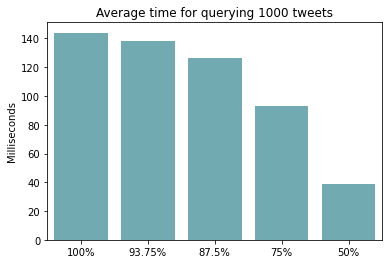

In [62]:
query_time_avgs = []
for col in query_time.columns:
    query_time_avgs.append(np.average(np.array(query_time[col])))

query_time_avgs2 = []
c = 0
acc = 0
for avg in query_time_avgs:
    if c < 2:
        acc += avg
        c += 1
        
    else:
        acc += avg
#         print(acc)
        query_time_avgs2.append(round(acc/3 , 4))
        acc = 0
        c = 0

for i in range(len(query_time_avgs2)):
    print('By using {} of terms, the average time for querying {} tweets is {} milliseconds'.format(PLOT_X[i], INDEX_TIME_UNIT, query_time_avgs2[i]))
compare_time(query_time_avgs2, 'Average time for querying {} tweets'.format(INDEX_TIME_UNIT))